In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [5]:
# Snowfall example

df = pd.read_csv('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2239075.csv?raw=true', parse_dates=[2])

df.tail(3) # We care about the DATE and SNOW columns

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18
19357,USC00190736,"BLUE HILL COOP, MA US",2020-05-09,0.45,0.0,0.0,57,34.0,34.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19358,USC00190736,"BLUE HILL COOP, MA US",2020-05-10,0.00,0.0,0.0,44,31.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19359,USC00190736,"BLUE HILL COOP, MA US",2020-05-11,0.00,0.0,0.0,59,38.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

def marginal(joint, axis):
    """Compute a marginal distribution."""
    return Pmf(joint.sum(axis=axis))

def plot_contour(joint):
    """Plot a joint distribution with a contour."""
    plt.contour(joint.columns, joint.index, joint,
                linewidths=2)
    
def normalize(joint):
    """Normalize a joint distribution."""
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

In [6]:
# Add a column that's just the "year" part of the dates

df['YEAR'] = df['DATE'].dt.year

# And use groupby to add up the snowfall for each year

snow = df.groupby('YEAR')['SNOW'].sum()

In [6]:
# We'll drop the 1st and last years because they're incomplete

snow = snow.iloc[1:-1]
len(snow)

52

<Axes: title={'center': 'Total annual snowfall, Norfolk County, MA'}, xlabel='Year', ylabel='Total annual snowfall (in)'>

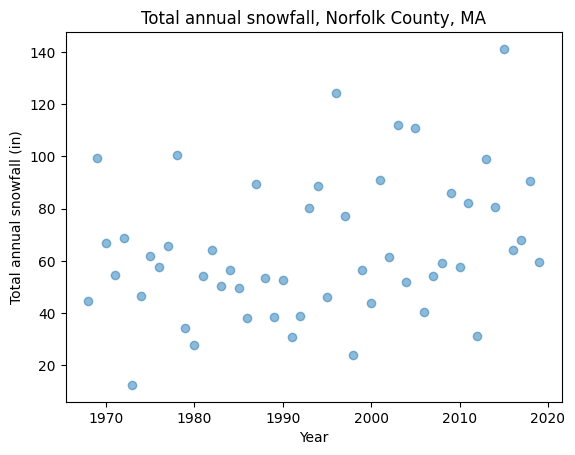

In [7]:
snow.plot(ls='', marker='o', alpha=0.5, xlabel='Year', ylabel='Total annual snowfall (in)', title='Total annual snowfall, Norfolk County, MA')

In [8]:
snow.loc[[1978, 1996, 2008, 2009, 2015]]

YEAR
1978    100.6
1996    124.2
2008     59.1
2009     85.8
2015    141.1
Name: SNOW, dtype: float64

In [7]:
# This is a simple linear regression. snow(y) = a*years(x) + epsilon, where epsilon is ~norm(0, sigma)
# To test whether the assumption around epsilon is reasonable, we'll plot the snowfall and a normal model with the same mean and SD

from empiricaldist import Pmf

In [8]:
pmf_snowfall = Pmf.from_seq(snow)
mean, std = pmf_snowfall.mean(), pmf_snowfall.std()
mean, std

(np.float64(62.56851851851851), np.float64(27.1357207799914))

In [9]:
# We'll use the scipy norm object to compute the CDF of a normal with the same mean and SD

from scipy.stats import norm

In [10]:
dist = norm(mean, std)
qs = pmf_snowfall.qs
ps = dist.cdf(qs)

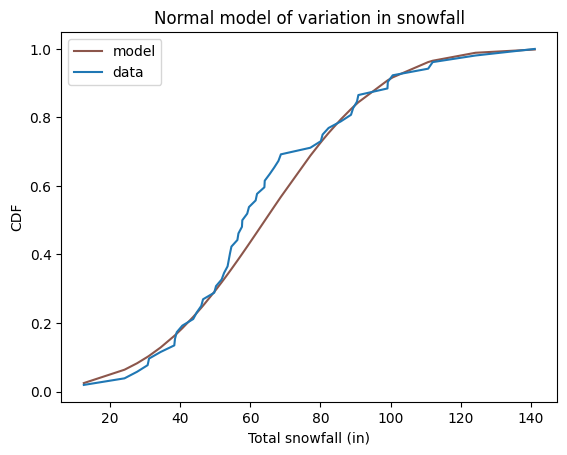

In [13]:
plt.plot(qs, ps, color='C5', label='model')
pmf_snowfall.make_cdf().plot(label='data')
plt.xlabel('Total snowfall (in)')
plt.ylabel('CDF')
plt.title('Normal model of variation in snowfall')
plt.legend() # This looks pretty close to a normal model

In [11]:
# Our regression model has 3 parameters: intercept, slope, and the SD of epsilon (sigma)
# To help generate priors, we'll fit a line to the data

# First we'll convert snow from a Series to a DataFrame

data = snow.reset_index()
data.head(3)

,YEAR,SNOW
0,1967,28.6
1,1968,44.7
2,1969,99.2


In [12]:
# As in the last chapter, we'll center the data by subtracting off the mean

offset = round(data['YEAR'].mean())
data['x'] = data['YEAR'] - offset
offset

1994

In [13]:
# Then add a column to data so the DV has a standard name

data['y'] = data['SNOW']

In [14]:
# Now we estimate slope and intercept from the data

import statsmodels.formula.api as smf

formula = 'y ~x'
results = smf.ols(formula, data=data).fit()
results.params

Intercept    62.780489
x             0.423941
dtype: float64

In [15]:
# The SD of the residuals is an estimate of sigma

results.resid.std()

np.float64(26.566114647742996)

In [16]:
# Priors

qs = np.linspace(-0.5, 1.5, 51)
prior_slope = make_uniform(qs, name='Slope')

qs = np.linspace(54, 75, 41)
prior_inter = make_uniform(qs, name='Intercept')

qs = np.linspace(20, 35, 31)
prior_sigma = make_uniform(qs, name='Sigma')

# The priors have different lengths for 2 reasons:
# 1. If we make a mistake and choose the wrong distribution, different lengths make it easier to detect
# 2. IT offers more precision for the slope parameter, which is the one we care about

# We'll make a joint prior, and wrap the process of a joint prior for 3 parameters in a function

def make_joint3(pmf1, pmf2, pmf3):
    joint2 = make_joint(pmf2, pmf1)
    joint3 = make_joint(pmf3, joint2)
    return Pmf(joint3.stack())

In [17]:
joint0 = make_joint(prior_inter, prior_slope)
joint0.columns.name = 'intercept'
joint0.index.name = 'slope'
joint0.head()

intercept,54.000,54.525,55.050,55.575,56.100,56.625,57.150,57.675,58.200,58.725,...,70.275,70.800,71.325,71.850,72.375,72.900,73.425,73.950,74.475,75.000
slope,,,,,,,,,,,,,,,,,,,,,
-0.50,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,...,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478
-0.46,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,...,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478
-0.42,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,...,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478
-0.38,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,...,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478
-0.34,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,...,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478,0.000478


In [18]:
joint0_pmf = Pmf(joint0.stack())
#joint0_pmf.index[0].name = 'slope'
#joint0_pmf.index[1].name = 'intercept'
joint0_pmf.head()

slope  intercept
-0.5   54.000       0.000478
       54.525       0.000478
       55.050       0.000478
dtype: float64

In [26]:
joint3 = make_joint(prior_sigma, joint0_pmf)
joint3.columns.name = 'sigma'
#joint3.index.name = ('slope', 'intercept')
#joint3.MultiIndex.from_tuples([list(t) for t in joint3.index], names=joint3.index.names)
joint3.shape

(2091, 31)

In [27]:
joint3_pmf = Pmf(joint3.stack())
#joint3_pmf.MultiIndex.from_tuples([list(t) for t in joint3_pmf.index], names=joint3_pmf.index.names)
joint3_pmf.head()

sigma
(-0.5, 54.0)  20.0     0.000015
              20.5     0.000015
              21.0     0.000015
dtype: float64

In [38]:
print(len(prior_slope) * len(prior_inter) * len(prior_sigma))

64821


In [39]:
print(len(prior))

64821


In [40]:
# To think through the calculation of the likelihood, assume temporarily that we know the values of the parameters

inter = 64
slope = 0.51
sigma = 25

xs = data['x']
ys = data['y']

# Then compute the residuals

expected = slope * xs + inter
resid = ys - expected

# The residuals should follow a normal dist with mean 0 and SD sigma; we can use this to calculate the likelihood of each resid value

densities = norm(0, sigma).pdf(resid)

likelihood = densities.prod()
likelihood

np.float64(1.3551948769060997e-105)

In [137]:
# Now we compute the likelihood for every possible set of parameters

likelihood = joint3_pmf.copy()

for ((slope, inter), sigma) in joint3_pmf.index:
    expected = slope * xs + inter
    resid = ys - expected
    densities = norm.pdf(resid, 0, sigma)
    likelihood[slope, inter, sigma] = densities.prod()

KeyError: 'Key length (3) exceeds index depth (2)'

In [138]:
likelihood = joint3_pmf.copy()

for slope in joint3_pmf.index.get_level_values('slope'):
    for inter in joint3_pmf.index.get_level_values('intercept'):
        for sigma in joint3_pmf.index.get_level_values('sigma'):
            expected = slope * xs + inter
            resid = ys - expected
            densities = norm.pdf(resid, 0, sigma)
            likelihood[slope, inter, sigma] = densities.prod()
        

KeyError: 'Level slope not found'

In [ ]:
# OK, I'm stuck. I can't get the 3-parameter model to work, and the lone exercise at the chapter's end requires it.
# Perhaps the lesson is that analyses with more than 2 parameters need different methods